In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import sklearn.metrics
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition, neighbors
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from statsmodels.graphics.api import abline_plot

In [14]:
# load processed csv file
filename = "fitbit_processed.csv"
# filename = "mi_processed.csv"

df = pd.read_csv(filename, index_col=None, header=0)
df = df.reset_index()
df

,index,Time,Length,Device,Action,Source
0,0,0.000,-14,Fitbit,0.5,0
1,1,0.196,32,Fitbit,0.5,0
2,2,0.290,-8,Fitbit,0.5,0
3,3,0.869,-14,Fitbit,0.5,0
4,4,2.030,-14,Fitbit,0.5,0
...,...,...,...,...,...,...
5334,5334,27.272,-32,Fitbit,3.0,9
5335,5335,28.351,-14,Fitbit,3.0,9
5336,5336,28.351,-32,Fitbit,3.0,9
5337,5337,29.162,-14,Fitbit,3.0,9


In [15]:
# create feature vector
# feature vector contains min/max/mean/count/std of packets and delta time
feature = {
    "incoming_min" : [],
    "incoming_max" : [],
    "incoming_mean": [],
    "incoming_count": [],
    "incoming_std": [],
    "outgoing_min" : [],
    "outgoing_max" : [],
    "outgoing_mean": [],
    "outgoing_count": [],
    "outgoing_std": [],
    "notnull_min" : [],
    "notnull_max" : [],
    "notnull_mean": [],
    "notnull_count": [],
    "notnull_std": [],
    "delta_min" : [],
    "delta_max" : [],
    "delta_mean": [],
    "delta_count": [],
    "delta_std": [], 
    "device" : [],
    "action": []
}

index_prev = 0
prev_time = 0
source_prev = 0
delta_time = []
for index, row in df.iterrows():
    # compute delta time
    delta_time.append(row['Time'] - prev_time)
    prev_time = row['Time']
    # loop every row
    if(row['Source'] != source_prev or index == len(df) - 1):
        if(index == len(df) - 1):
            index = index + 1
        # for every action
        # compute the statistical for ingoing packet length
        if(len([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y > 0]) == 0):
            feature.get("incoming_min").append(0)
            feature.get("incoming_max").append(0)
            feature.get("incoming_mean").append(0)
            feature.get("incoming_count").append(0)
            feature.get("incoming_std").append(0)  
        else:
            feature.get("incoming_min").append(np.min([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y > 0]))
            feature.get("incoming_max").append(np.max([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y > 0]))
            feature.get("incoming_mean").append(np.mean([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y > 0]))
            feature.get("incoming_count").append(len([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y > 0]))
            feature.get("incoming_std").append(np.std([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y > 0]))
        # compute the statistical for outgoing packet length
        if(len([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y < 0]) == 0):
            feature.get("outgoing_min").append(0)
            feature.get("outgoing_max").append(0)
            feature.get("outgoing_mean").append(0)
            feature.get("outgoing_count").append(0)
            feature.get("outgoing_std").append(0)      
        else:
            feature.get("outgoing_min").append(np.min([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y < 0]))
            feature.get("outgoing_max").append(np.max([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y < 0]))
            feature.get("outgoing_mean").append(np.mean([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y < 0]))
            feature.get("outgoing_count").append(len([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y < 0]))
            feature.get("outgoing_std").append(np.std([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y < 0]))
        # compute statistical for all packet length
        feature.get("notnull_min").append(np.min([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y != 0]))
        feature.get("notnull_max").append(np.max([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y != 0]))
        feature.get("notnull_mean").append(np.mean([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y != 0]))
        feature.get("notnull_count").append(len([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y != 0]))
        feature.get("notnull_std").append(np.std([abs(y) for y in df['Length'].loc[index_prev : index - 1] if y != 0]))
        # compute statistical for delta time
        feature.get("delta_min").append(np.min(delta_time))
        feature.get("delta_max").append(np.max(delta_time))
        feature.get("delta_mean").append(np.mean(delta_time))
        feature.get("delta_count").append(len(delta_time))
        feature.get("delta_std").append(np.std(delta_time))
        # create labels
        feature.get("device").append(row['Device'])
        feature.get("action").append(row['Action'])
        source_prev = row['Source']
        prev_time = 0

        index_prev = index        


feature
features = pd.DataFrame(feature)
features

,incoming_min,incoming_max,incoming_mean,incoming_count,incoming_std,outgoing_min,outgoing_max,outgoing_mean,outgoing_count,outgoing_std,...,notnull_mean,notnull_count,notnull_std,delta_min,delta_max,delta_mean,delta_count,delta_std,device,action
0,10,130,40.0000,8,34.856850,8,32,20.707692,65,9.642411,...,22.821918,73,15.882568,-29.869,1.161,0.000000e+00,74,3.510542,Fitbit,0.5
1,32,32,32.0000,5,0.000000,8,32,21.354839,62,9.481896,...,22.149254,67,9.540571,-29.869,1.161,0.000000e+00,141,3.555494,Fitbit,0.5
2,32,32,32.0000,5,0.000000,8,32,17.957447,47,8.419727,...,19.307692,52,9.011827,-29.869,1.162,2.761176e-17,193,3.711189,Fitbit,0.5
3,14,194,120.0625,32,84.038658,8,194,78.818841,138,84.809098,...,86.582353,170,86.185960,-29.869,1.162,1.957418e-17,363,3.132317,Fitbit,0.5
4,32,32,32.0000,5,0.000000,8,32,21.000000,60,9.433981,...,21.846154,65,9.526047,-29.869,1.162,2.075183e-17,428,3.220949,Fitbit,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,32,32,32.0000,2,0.000000,8,32,22.516129,62,9.241809,...,22.812500,64,9.244720,-29.958,1.668,4.187052e-18,5091,3.650200,Fitbit,3.0
76,32,32,32.0000,2,0.000000,8,32,22.200000,60,9.228218,...,22.516129,62,9.241809,-29.958,1.668,9.996963e-18,5153,3.652139,Fitbit,3.0
77,32,32,32.0000,2,0.000000,8,32,22.200000,60,9.228218,...,22.516129,62,9.241809,-29.958,1.668,2.724996e-18,5215,3.653615,Fitbit,3.0
78,32,32,32.0000,2,0.000000,8,32,22.033898,59,9.216724,...,22.360656,61,9.236479,-29.958,1.668,5.050294e-18,5276,3.655656,Fitbit,3.0


In [27]:
# speed regressor
actions = np.array(features['action'])
y = pd.Series(actions)

X_features = features.drop(['device', 'action'], axis = 1)
X_features = np.array(X_features)
y = np.array(y)
print(X_features)

[[1.00000000e+01 1.30000000e+02 4.00000000e+01 ... 0.00000000e+00
  7.40000000e+01 3.51054230e+00]
 [3.20000000e+01 3.20000000e+01 3.20000000e+01 ... 0.00000000e+00
  1.41000000e+02 3.55549413e+00]
 [3.20000000e+01 3.20000000e+01 3.20000000e+01 ... 2.76117643e-17
  1.93000000e+02 3.71118881e+00]
 ...
 [3.20000000e+01 3.20000000e+01 3.20000000e+01 ... 2.72499611e-18
  5.21500000e+03 3.65361503e+00]
 [3.20000000e+01 3.20000000e+01 3.20000000e+01 ... 5.05029427e-18
  5.27600000e+03 3.65565615e+00]
 [3.20000000e+01 3.20000000e+01 3.20000000e+01 ... 5.48716988e-03
  5.33900000e+03 3.63462560e+00]]


[0.5 0.5 1.  1.  1.  3.  3.  3. ]
[0.5000308  0.5000308  1.00001752 1.00001752 1.00001752 2.9999644
 2.9999644  2.9999644 ]
[0.5 0.5 0.5 1.  2.  3.  3.  3. ]
[0.50003062 0.50003062 0.50003062 1.00001734 1.99999078 2.99996422
 2.99996422 2.99996422]
[0.5 0.5 1.  1.  1.  2.  2.  3. ]
[0.50003154 0.50003154 1.00001826 1.00001826 1.00001826 1.9999917
 1.9999917  2.99996514]
[0.5 0.5 1.  1.  2.  2.  3.  3. ]
[0.5000308  0.5000308  1.00001752 1.00001752 1.99999096 1.99999096
 2.9999644  2.9999644 ]
[2. 2. 2. 2. 2. 3. 3. 3.]
[1.99998875 1.99998875 1.99998875 1.99998875 1.99998875 2.99996219
 2.99996219 2.99996219]
[0.5 0.5 0.5 1.  1.  1.  2.  2. ]
[0.50003246 0.50003246 0.50003246 0.50003246 1.00001918 1.00001918
 1.99999262 1.99999262]
[1. 1. 2. 2. 2. 2. 3. 3.]
[1.00001642 1.00001642 1.99998986 1.99998986 1.99998986 1.99998986
 2.99996329 2.99996329]
[0.5 0.5 0.5 1.  3.  3.  3.  3. ]
[0.50003025 0.50003025 0.50003025 1.00001697 2.99996385 2.99996385
 2.99996385 2.99996385]
[0.5 0.5 1.  1.  2

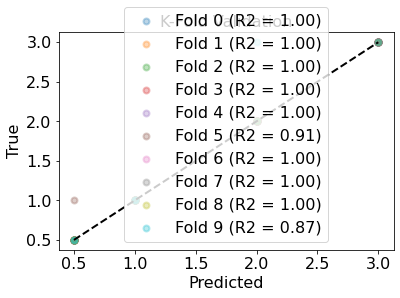

[0.50003117 0.50003117 1.00001789 1.00001789 1.00001789 1.99999133
 1.99999133 2.99996477]
[0.5 0.5 1.  1.  1.  2.  3.  3. ]
R2 (explained variance): 0.87
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.06
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
[0.5 1.  1.  2.  2.  3.  3.  3. ]
[0.50002988 1.0000166  1.0000166  1.99999004 1.99999004 2.99996348
 2.99996348 2.99996348]
[0.5 0.5 0.5 1.  2.  2.  3.  3. ]
[0.50003099 0.50003099 0.50003099 1.00001771 1.99999115 1.99999115
 2.99996458 2.99996458]
[0.5 0.5 1.  1.  3.  3.  3.  3. ]
[0.50003007 0.50003007 1.00001679 1.00001679 2.99996366 2.99996366
 2.99996366 2.99996366]
[0.5 0.5 0.5 1.  1.  2.  2.  3. ]
[0.50003173 0.50003173 0.50003173 1.00001845 1.00001845 1.99999188
 1.99999188 2.99996532]
[0.5 1.  1.  1.  2.  2.  2.  3. ]
[0.50003099 1.00001771 1.00001771 1.00001771 1.99999115 1.99999115
 1.99999115 2.99996458]
[0.5 0.5 0.5 1.  1.  2.  2.  2. ]
[0.5000321  0.5000321  0.5000321  1.00001881 1.0000

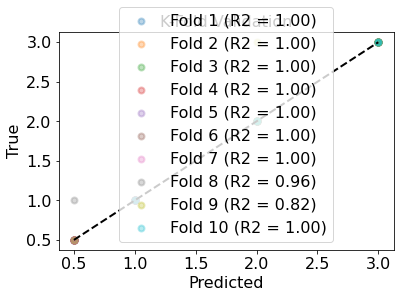

[1.00001605 1.00001605 1.99998949 1.99998949 1.99998949 2.99996292
 2.99996292 2.99996292]
[1. 1. 2. 2. 2. 3. 3. 3.]
R2 (explained variance): 1.0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.0
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
[0.5 0.5 1.  1.  2.  2.  3.  3. ]
[0.5000308  0.5000308  1.00001752 1.00001752 1.99999096 1.99999096
 2.9999644  2.9999644 ]
[0.5 0.5 0.5 1.  1.  2.  3.  3. ]
[0.50003136 0.50003136 0.50003136 1.00001808 1.00001808 1.99999152
 2.99996495 2.99996495]
[0.5 1.  2.  2.  2.  3.  3.  3. ]
[0.50002951 1.00001623 1.99998967 1.99998967 1.99998967 2.99996311
 2.99996311 2.99996311]
[0.5 1.  1.  1.  2.  3.  3.  3. ]
[0.50003025 1.00001697 1.00001697 1.00001697 1.99999041 2.99996385
 2.99996385 2.99996385]
[1. 2. 2. 2. 2. 3. 3. 3.]
[1.00001568 1.99998912 1.99998912 1.99998912 1.99998912 2.99996256
 2.99996256 2.99996256]
[0.5 0.5 1.  1.  1.  1.  2.  3. ]
[0.50003191 0.50003191 1.00001863 1.00001863 1.00001863 1.00001863
 1

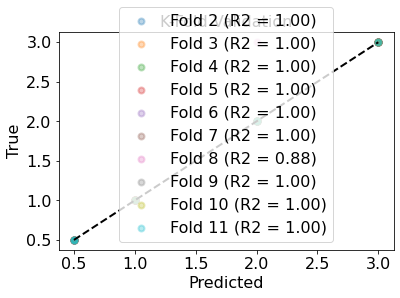

[0.50003099 0.50003099 0.50003099 1.00001771 1.99999115 1.99999115
 2.99996458 2.99996458]
[0.5 0.5 0.5 1.  2.  2.  3.  3. ]
R2 (explained variance): 1.0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.0
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
[0.5 0.5 0.5 0.5 1.  2.  2.  2. ]
[0.50003228 0.50003228 0.50003228 0.50003228 1.000019   1.99999244
 1.99999244 1.99999244]
[0.5 1.  1.  2.  2.  3.  3.  3. ]
[0.50002988 1.0000166  1.0000166  1.99999004 1.99999004 2.99996348
 2.99996348 2.99996348]
[1. 2. 2. 3. 3. 3. 3. 3.]
[1.00001494 1.99998838 1.99998838 1.99998838 2.99996182 2.99996182
 2.99996182 2.99996182]
[0.5 0.5 0.5 1.  1.  1.  1.  3. ]
[0.50003246 0.50003246 0.50003246 1.00001918 1.00001918 1.00001918
 1.00001918 2.99996606]
[0.5 0.5 0.5 1.  1.  2.  3.  3. ]
[0.50003136 0.50003136 0.50003136 1.00001808 1.00001808 1.99999152
 2.99996495 2.99996495]
[0.5 0.5 1.  1.  1.  1.  2.  3. ]
[0.50003191 0.50003191 1.00001863 1.00001863 1.00001863 1.000

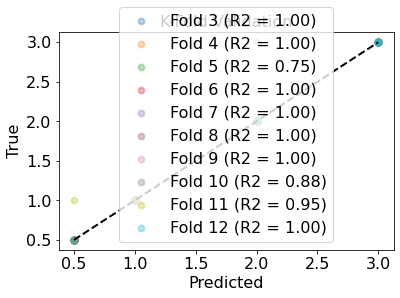

[0.50002914 1.9999893  1.9999893  1.9999893  1.9999893  2.99996274
 2.99996274 2.99996274]
[0.5 2.  2.  2.  2.  3.  3.  3. ]
R2 (explained variance): 1.0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.0
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
[0.5 0.5 0.5 1.  1.  1.  2.  2. ]
[0.50003246 0.50003246 0.50003246 1.00001918 1.00001918 1.00001918
 1.99999262 1.99999262]
[0.5 0.5 0.5 1.  1.  1.  2.  3. ]
[0.5000321  0.5000321  0.5000321  1.00001881 1.00001881 1.00001881
 1.99999225 2.99996569]
[1. 1. 2. 2. 2. 3. 3. 3.]
[0.50002933 1.00001605 1.99998949 1.99998949 1.99998949 2.99996292
 2.99996292 2.99996292]
[0.5 0.5 0.5 1.  1.  1.  2.  3. ]
[0.5000321  0.5000321  0.5000321  1.00001881 1.00001881 1.00001881
 1.99999225 2.99996569]
[0.5 1.  2.  2.  3.  3.  3.  3. ]
[0.50002914 1.00001586 1.9999893  1.9999893  2.99996274 2.99996274
 2.99996274 2.99996274]
[0.5 0.5 1.  1.  2.  3.  3.  3. ]
[0.50003043 0.50003043 1.00001715 1.00001715 1.99999059 2.999

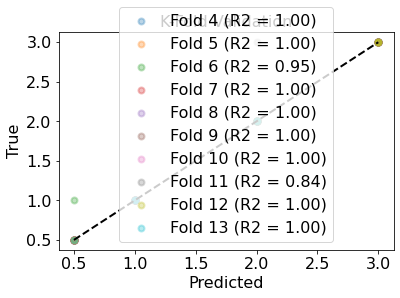

[0.50003173 1.00001845 1.00001845 1.00001845 1.00001845 1.99999188
 1.99999188 1.99999188]
[0.5 1.  1.  1.  1.  2.  2.  2. ]
R2 (explained variance): 1.0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.0
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
###############
[0.5000311727528611, 0.5000311727528611, 1.0000178920534173, 1.0000178920534173, 1.0000178920534173, 1.9999913306545298, 1.9999913306545298, 2.9999647692556417, 1.0000160475118283, 1.0000160475118283, 1.9999894861129401, 1.9999894861129401, 1.9999894861129401, 2.999962924714053, 2.999962924714053, 2.999962924714053, 0.5000309882987022, 0.5000309882987021, 0.5000309882987021, 1.0000177075992582, 1.9999911462003708, 1.9999911462003708, 2.9999645848014835, 2.9999645848014835, 0.5000291437571129, 1.9999893016587813, 1.9999893016587813, 1.9999893016587813, 1.9999893016587813, 2.999962740259894, 2.999962740259894, 2.999962740259894, 0.5000317261153379, 1.000018445415894, 1.000018445415894, 1.0

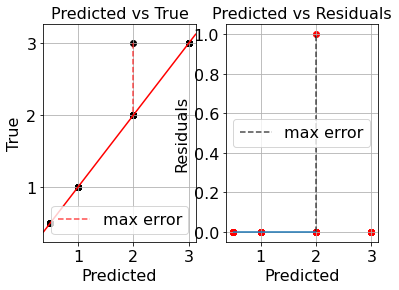

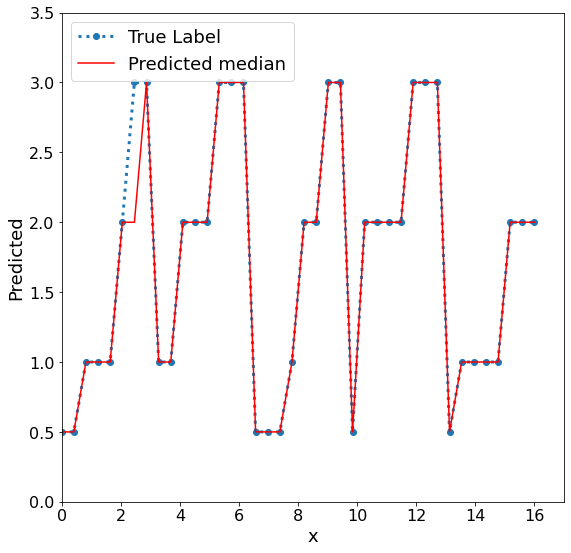

In [33]:
scores = []
cv = model_selection.KFold(n_splits=10, shuffle=True)
fig = plt.figure()
i = 1
Y = []
PRE = []
RES = []

# Gradient Boosting Regressor
model = ensemble.GradientBoostingRegressor()

for i in range(0, 5):
    for train, test in cv.split(X_features, y):
        X_train, X_test = X_features[train], X_features[test]
        y_train, y_test = y[train], y[test]        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(y_test)
        print(y_pred)
        score = metrics.r2_score(y_test, y_pred)
        scores.append(score)
        plt.scatter(y_pred, y_test, lw=2, alpha=0.3,
                    label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)],
             linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('K-Fold Validation')
    plt.legend()
    plt.show()

    ## test
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    print(predicted)
    print(y_test)

    Y.extend(y_test)
    PRE.extend(predicted)

    ## Kpi
    print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
    
    ## residuals
    residuals = y_test - predicted
    RES.extend(residuals)


print("###############")
print(PRE)
print(Y)

max_error = max(RES) if abs(max(RES)) > abs(min(RES)) else min(RES)
max_idx = list(RES).index(max(RES)) if abs(max(RES)) > abs(min(RES)) else list(RES).index(
    min(RES))
max_true, max_pred = Y[max_idx], PRE[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(PRE, Y, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true - max_error, color='red', linestyle='--', alpha=0.7,
             label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()

## Plot predicted vs residuals
ax[1].scatter(PRE, RES, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()


xx = np.atleast_2d(np.linspace(0, 16, 40)).T

fig = plt.figure(figsize=(9, 9))
plt.plot(xx, Y, "o:", linewidth=3, label="True Label")
plt.plot(xx, PRE, "red", label="Predicted median")
plt.xlabel("x", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.xlim(0, 17, 0.5)
plt.ylim(0, 3.5, 0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
leg = plt.legend(loc="upper left", fontsize=18)
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.show()